## Machine Learning Accelerator Computer Vision - Final Project - Day 1

In this project, you will train Convolutional Neural Networks to correctly classify images of luggages. The competition is hosted here: https://mlu.corp.amazon.com/contests/redirect/50

We have a total of 5 classes and they are:
* Class 0: Inconclusive
* Class 1: Two wheels
* Class 2: Four wheels
* Class 3: Not a luggage
* Class 4: Zero wheels

__You can use the MLA-CV-DAY1-CNN.ipynb notebook as a starting point__. Create a simple Convolutional Neural Network, train, val and test it with the provided datasets.

Let's import all the libraries. Before that, make sure you have installed the required version our libraries as below.

In [1]:
! pip install -q nvidia-ml-py3==7.352.0
! pip install -q torch==1.8.0
! pip install -q torchvision==0.9.0
! pip install -q d2l==0.16.0
! pip install -q numpy==1.19.5

In [1]:
import os
import d2l
from skimage.io import imread
import torch, torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import SGD

### 1. Reading the dataset and creating loaders:

Your final project dataset is now under the __"data/final_project_dataset"__ folder. Over there you will see the __training__, __validation__ and __test__ folders. Let's start creating the data transforms and loaders below. In this project, images come in different sizes and we will resize them to 224x224 and normalize pixel values.

In [2]:
# Use GPU resource if available, otherwise wil use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 16

path = '../../data/final_project_dataset'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'validate')
test_path = os.path.join(path, 'test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

train_loader = DataLoader(
    ImageFolder(train_path, transform=transform),
    batch_size=batch_size, shuffle=True)

validation_loader = DataLoader(
    ImageFolder(val_path, transform=transform),
    batch_size=batch_size, shuffle=False)

test_loader = DataLoader(
    ImageFolder(test_path, transform=transform),
    batch_size=batch_size, shuffle=False)

Let's see some sample pictures.

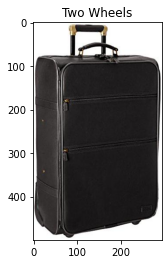

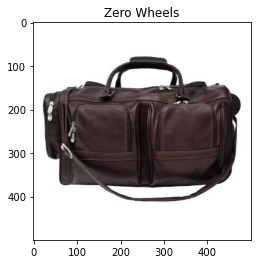

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

im1 = imread(train_path + "/class_1/B003AOIJ74.jpg")
im2 = imread(train_path + "/class_4/B002GQRGOY.jpg")

plt.imshow(im1)
plt.title("Two Wheels")
plt.show()
plt.imshow(im2)
plt.title("Zero Wheels")
plt.show()

### 2. Training and Validation

In this part, you will use a simple Convolutional Neural Network. You can start with a network that we discuss in the class today. You will use the __train_loader__ and __validation_loader__ from above. 

Some important notes:
* There are 5 classes in this project, so adjust the network's last dense layer for that
* Once the tranining runs without errors, experiment with batch_size (in the data loaders part) and learning rate in your code. 

In [4]:
## Build and train/validate your model here
out_classes = 5

net = nn.Sequential(
    # First Conv. layer
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
    nn.ReLU(),
    # First Max Pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Second Conv. layer
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),
    nn.ReLU(),
    # Second Max Pooling layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    # The Flatten layer collapses all axis, 
    # except the first one, into one axis.
    nn.Flatten(),
    # Fully Connected or Dense Layer
    nn.Linear(53*53*16, 32),
    nn.ReLU(),
    # Output layer
    nn.Linear(32, out_classes)).to(device)

In [6]:
epochs = 15
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

In [7]:
optimizer = SGD(net.parameters(), lr=learning_rate)

In [8]:
def calculate_accuracy(output, label):
    """Calculate the accuracy of the trained network. 
    output: (batch_size, num_output) float32 tensor
    label: (batch_size, ) int32 tensor """
    
    return (output.argmax(axis=1) == label.float()).float().mean()

In [9]:
for epoch in range(epochs):
    net = net.to(device)
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop:
    # This loop trains the neural network (weights are updated)
    net.train() # Activate training mode
    for data, label in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Put data and label to the correct device
        data = data.to(device)
        label = label.to(device)
        # Make forward pass
        output = net(data)
        # Calculate loss
        loss = criterion(output, label)
        # Make backwards pass (calculate gradients)
        loss.backward()
        # Accumulate training accuracy and loss
        train_acc += calculate_accuracy(output, label).item()
        train_loss += loss.item()
        # Update weights
        optimizer.step()
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    # torch.no_grad() reduces memory usage when not training the network
    net.eval() # Activate evaluation mode
    with torch.no_grad():
        for data, label in validation_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = net(data)
            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label).item()
            val_loss += criterion(output, label).item()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch+1, train_loss, train_acc, val_loss, valid_acc))

Epoch 1: train loss 1.349, train acc 0.388, val loss 1.282, val acc 0.404
Epoch 2: train loss 1.273, train acc 0.403, val loss 1.252, val acc 0.404
Epoch 3: train loss 1.239, train acc 0.427, val loss 1.294, val acc 0.379
Epoch 4: train loss 1.207, train acc 0.437, val loss 1.209, val acc 0.404
Epoch 5: train loss 1.171, train acc 0.448, val loss 1.181, val acc 0.434
Epoch 6: train loss 1.144, train acc 0.465, val loss 1.154, val acc 0.449
Epoch 7: train loss 1.111, train acc 0.496, val loss 1.917, val acc 0.331
Epoch 8: train loss 1.089, train acc 0.502, val loss 1.047, val acc 0.464
Epoch 9: train loss 1.149, train acc 0.491, val loss 1.126, val acc 0.469
Epoch 10: train loss 1.011, train acc 0.548, val loss 1.110, val acc 0.488
Epoch 11: train loss 0.975, train acc 0.569, val loss 1.021, val acc 0.570
Epoch 12: train loss 0.910, train acc 0.591, val loss 0.904, val acc 0.577
Epoch 13: train loss 0.910, train acc 0.617, val loss 0.995, val acc 0.591
Epoch 14: train loss 0.815, train 

### 3. Reading the test data and getting predictions

After you trained your model, it is time to read our test set and make predictions with it. Then, we will write our predictions to a csv file that thas "ID" and "label" columns. This will be our final project submission file.

In [18]:
import pandas as pd

test_df = pd.read_csv("../../data/final_project_dataset/public_test_features.csv")
print(test_df.head())

     ID        ASIN
0  1453  B00M8TTDM2
1   655  B005544142
2  1178  B00TKFGAEQ
3   548  B07G9YMP3R
4  1547  B0198M4NHQ


Let's load the test images and start creating our csv file. Here, we add a new column named "label". We write model's predictions to this column. 

In [26]:
import numpy as np

file_index = 0
files = ImageFolder(test_path, transform=transform).samples
test_df["label"] = np.nan
test_acc = 0.
net.eval() # Activate "evaluate" mode
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        #label = label.to(device)
        pred = net(data)
        #test_acc += calculate_accuracy(output, label).item()
        # Get test predictions
        predictions = pred.argmax(axis=1).detach().cpu().tolist()
        # Write predictions to the test data frame
        for pred in predictions:
            test_df.loc[test_df["ASIN"]==files[file_index][0].split("/")[-1].split(".jpg")[0], "label"] = pred
            file_index += 1
            
#test_acc = test_acc/len(test_loader)
#print("Test accuracy: %.3f" % test_acc)

## 4. Submit your predictions

This is the last step. The code block below will create a csv file: __final_project.csv__ with ID and label (your predictions) columns and then you will submit it to the leaderboard: https://mlu.corp.amazon.com/contests/redirect/50 "ASIN" column is not needed, so we drop it.

In [13]:
import pandas as pd

test_df.drop(columns=["ASIN"], inplace=True)

test_df.to_csv("final_project.csv", index=False)